## Máster en Data Science - Series Temporales

# Decision Tree Model
Autor: Ramón Morillo Barrera

## Dataset: Madrid.csv

La predicción de series temporales con árboles de decisión es un enfoque basado en modelos de aprendizaje automático que ofrece una alternativa flexible y no paramétrica a los métodos tradicionales. En lugar de asumir relaciones lineales o dependencias específicas entre los datos, los árboles de decisión dividen el espacio de entrada en subconjuntos basados en reglas de decisión, lo que permite capturar patrones complejos y no lineales en las series temporales. Para aplicar este enfoque, las series suelen transformarse en un conjunto de características predictoras (lags, tendencias, estacionalidades, etc.) y una variable objetivo, facilitando la predicción de valores futuros. Este método puede extenderse mediante modelos más avanzados como Random Forests o Gradient Boosting, que combinan múltiples árboles para mejorar la precisión y la robustez de las predicciones.

In [9]:
# librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


warnings.filterwarnings("ignore")

### Importación de datos

In [2]:
df_autobus_month = pd.read_csv('../data/processed/Madrid_autobus_month.csv', index_col='Periodo')
df_metro_month = pd.read_csv('../data/processed/Madrid_metro_month.csv', index_col='Periodo')
df_combined_month = pd.read_csv('../data/processed/Madrid_combined_month.csv', index_col='Periodo')

df_autobus_trim = pd.read_csv('../data/processed/Madrid_autobus_trim.csv', index_col='Periodo')
df_metro_trim = pd.read_csv('../data/processed/Madrid_metro_trim.csv', index_col='Periodo')
df_combined_trim = pd.read_csv('../data/processed/Madrid_combined_trim.csv', index_col='Periodo')

In [3]:
df_autobus_month = df_autobus_month[ 'Total']
df_autobus_trim = df_autobus_trim['Total']
df_combined_month = df_combined_month[ 'Total']
df_combined_trim = df_combined_trim['Total']
df_metro_month = df_metro_month['Total']
df_metro_trim = df_metro_trim['Total']

In [4]:
df_autobus_month.index = pd.to_datetime(df_autobus_month.index)
df_autobus_trim.index = pd.to_datetime(df_autobus_trim.index)
df_combined_month.index = pd.to_datetime(df_combined_month.index)
df_combined_trim.index = pd.to_datetime(df_combined_trim.index)
df_metro_month.index = pd.to_datetime(df_metro_month.index)
df_metro_trim.index = pd.to_datetime(df_metro_trim.index)

df_autobus_month = df_autobus_month.resample("M").last()
df_autobus_trim = df_autobus_trim.resample("QE").last()
df_combined_month = df_combined_month.resample("M").last()
df_combined_trim = df_combined_trim.resample("QE").last()
df_metro_month = df_metro_month.resample("M").last()
df_metro_trim = df_metro_trim.resample("QE").last()

***
## Modelo Decision Tree

DecisionTreeRegressor es un modelo de aprendizaje automático supervisado utilizado para problemas de regresión, donde el objetivo es predecir un valor continuo. Este modelo divide los datos en subconjuntos más pequeños mediante reglas de decisión basadas en características de entrada, organizándolos en una estructura jerárquica conocida como árbol. En cada nodo del árbol, se selecciona la división que minimiza la varianza en las respuestas del conjunto de datos, buscando particiones que produzcan predicciones más precisas. DecisionTreeRegressor es altamente flexible y no requiere que los datos sigan una relación lineal, lo que lo hace adecuado para capturar patrones complejos. Sin embargo, puede ser propenso al sobreajuste si no se regulariza adecuadamente mediante parámetros como la profundidad máxima del árbol o el número mínimo de muestras en un nodo.

### Series mensuales

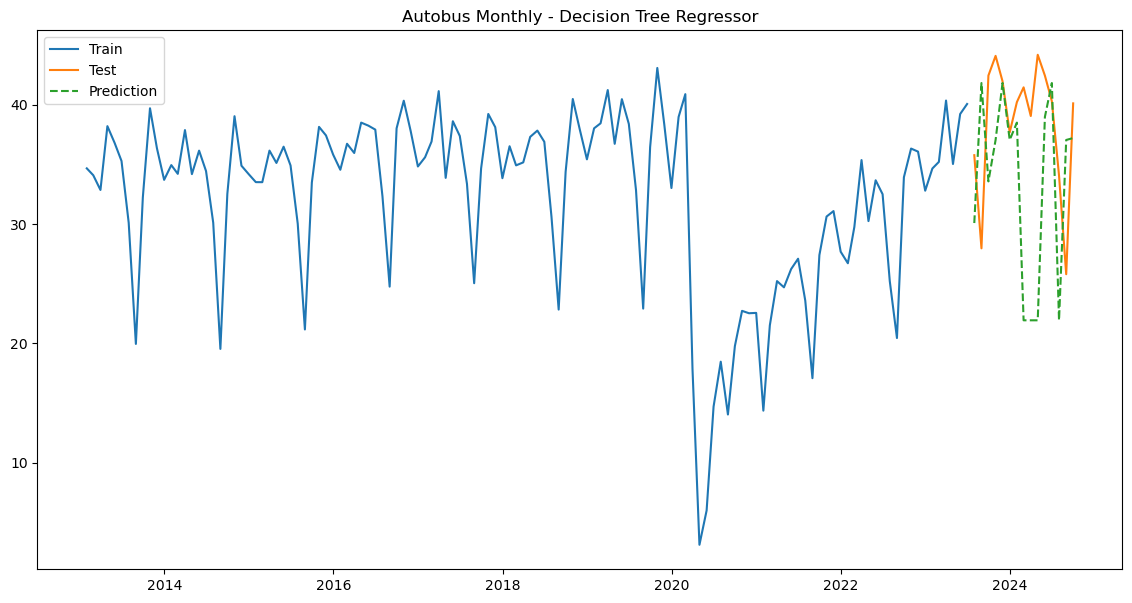

R2 Score Train: 0.9609191418585185
R2 Score Test: -3.2895947411747777


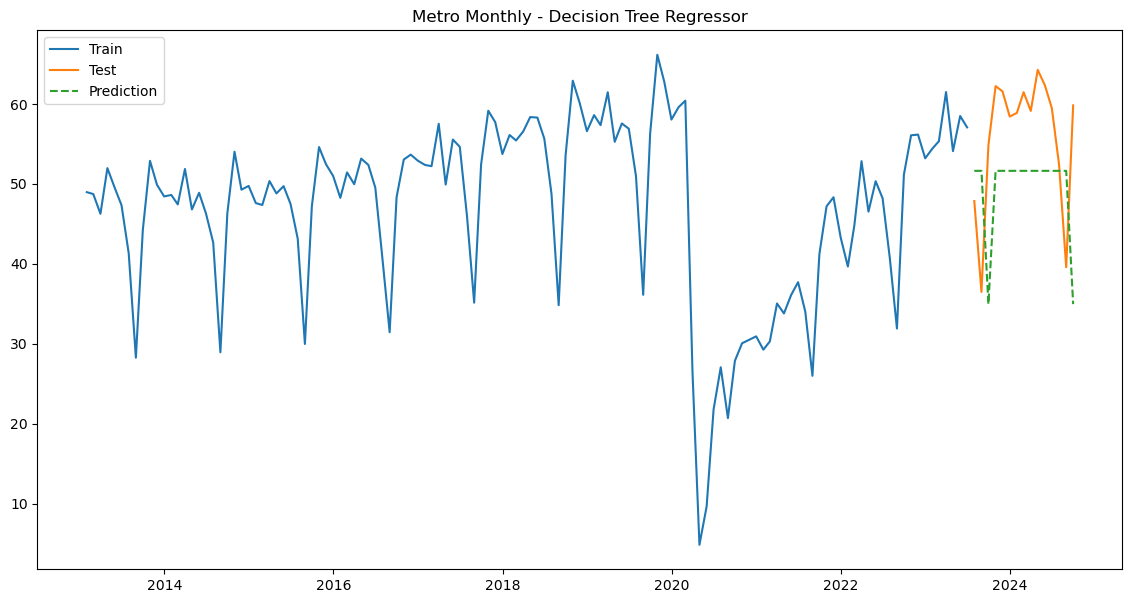

R2 Score Train: 0.4470929285315146
R2 Score Test: -1.2235915670197803


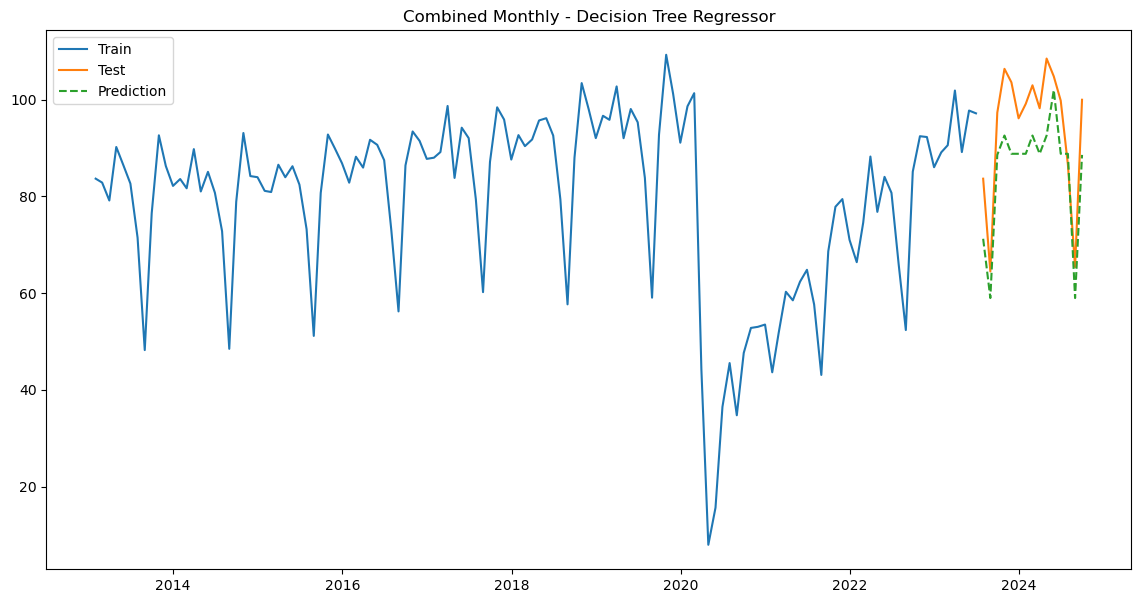

R2 Score Train: 0.8420516361214837
R2 Score Test: 0.39781679342144005


In [16]:
# Definir una función para preparar los datos, entrenar el modelo y hacer predicciones
def train_and_predict(df, test_size, title):
    # Crear características (lags)
    df_lagged = pd.concat([df.shift(i) for i in range(1, 13)], axis=1)
    df_lagged.columns = [f'lag_{i}' for i in range(1, 13)]
    df_lagged['target'] = df.values
    df_lagged.dropna(inplace=True)
    
    # Separar en train y test
    X = df_lagged.drop(columns='target')
    y = df_lagged['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    
    # Definir el modelo y los parámetros para GridSearchCV
    model = DecisionTreeRegressor(random_state=42)
    param_grid = {
        'max_depth': np.random.randint(1, 10, 10),
        'min_samples_split': np.random.randint(1, 10, 10),
        'min_samples_leaf': np.random.randint(1, 10, 10)
    }
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    
    # Mejor modelo
    best_model = grid_search.best_estimator_
    
    # Predicciones
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Graficar resultados
    plt.figure(figsize=(14, 7))
    plt.plot(df.index[-len(y_train)-len(y_test):-len(y_test)], y_train, label='Train')
    plt.plot(df.index[-len(y_test):], y_test, label='Test')
    plt.plot(df.index[-len(y_test):], y_test_pred, label='Prediction', linestyle='--')
    plt.title(f'{title} - Decision Tree Regressor')
    plt.legend()
    plt.show()
    
    # Métricas
    print(f'R2 Score Train: {r2_score(y_train, y_train_pred)}')
    print(f'R2 Score Test: {r2_score(y_test, y_test_pred)}')

# Aplicar la función a los dataframes mensuales
train_and_predict(df_autobus_month, test_size=15, title='Autobus Monthly')
train_and_predict(df_metro_month, test_size=15, title='Metro Monthly')
train_and_predict(df_combined_month, test_size=15, title='Combined Monthly')

In [17]:
# Definir una función para calcular las métricas
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, rmse, mape

# Calcular las métricas para cada serie temporal
def print_metrics(df, test_size, title):
    df_lagged = pd.concat([df.shift(i) for i in range(1, 13)], axis=1)
    df_lagged.columns = [f'lag_{i}' for i in range(1, 13)]
    df_lagged['target'] = df.values
    df_lagged.dropna(inplace=True)
    
    X = df_lagged.drop(columns='target')
    y = df_lagged['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    
    model = DecisionTreeRegressor(random_state=42)
    param_grid = {
        'max_depth': np.random.randint(1, 10, 10),
        'min_samples_split': np.random.randint(1, 10, 10),
        'min_samples_leaf': np.random.randint(1, 10, 10)
    }
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_test_pred = best_model.predict(X_test)
    
    mse, rmse, mape = calculate_metrics(y_test, y_test_pred)
    
    print(f'{title} - MSE: {mse}, RMSE: {rmse}, MAPE: {mape}')

# Imprimir las métricas para cada serie temporal
print_metrics(df_autobus_month, test_size=15, title='Autobus Monthly')
print_metrics(df_metro_month, test_size=15, title='Metro Monthly')
print_metrics(df_combined_month, test_size=15, title='Combined Monthly')

Autobus Monthly - MSE: 118.04182969593623, RMSE: 10.864705688417715, MAPE: 0.22341547028112746
Metro Monthly - MSE: 55.36284859523388, RMSE: 7.440621519418514, MAPE: 0.11004889710943516
Combined Monthly - MSE: 105.55247662744608, RMSE: 10.273873496760903, MAPE: 0.09964791383038317


### Series trimestrales

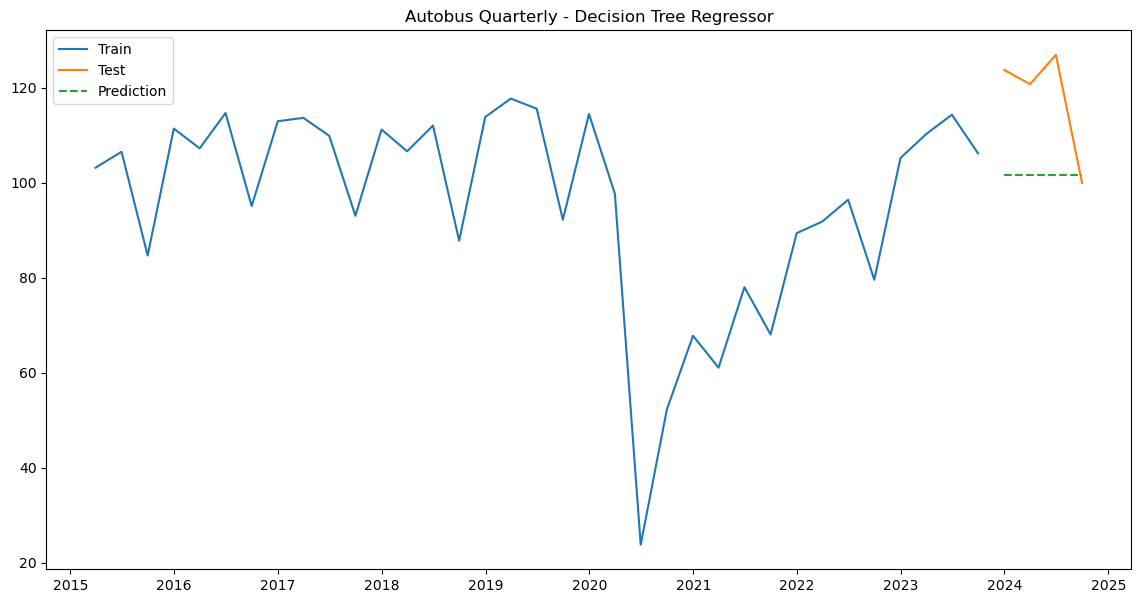

R2 Score Train: 0.3379982586896245
R2 Score Test: -2.3465010778863284


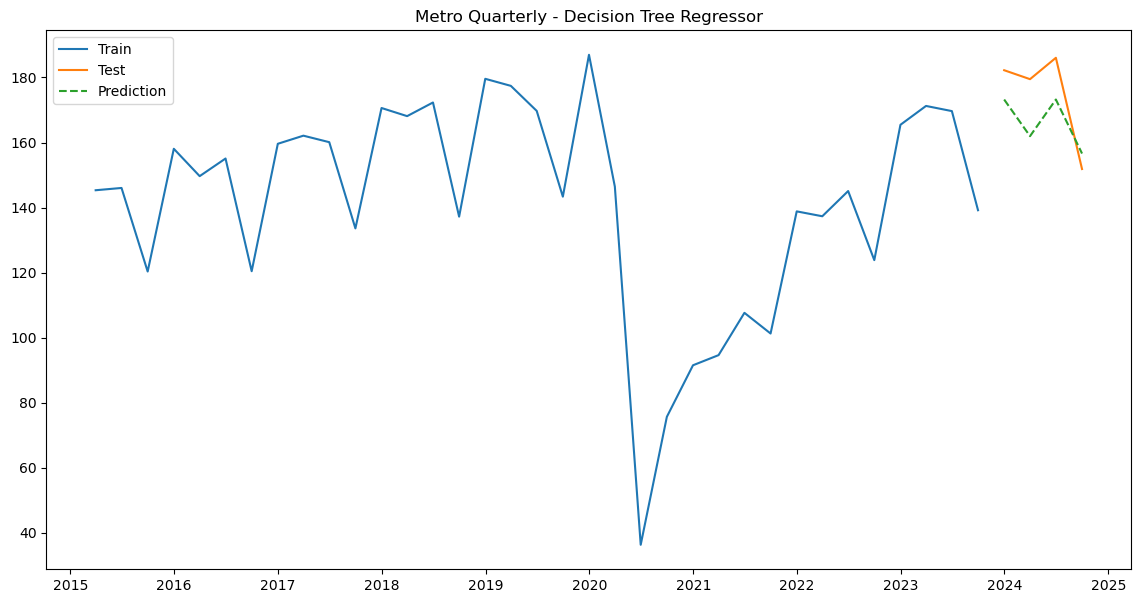

R2 Score Train: 0.6635533614975835
R2 Score Test: 0.21212777673639838


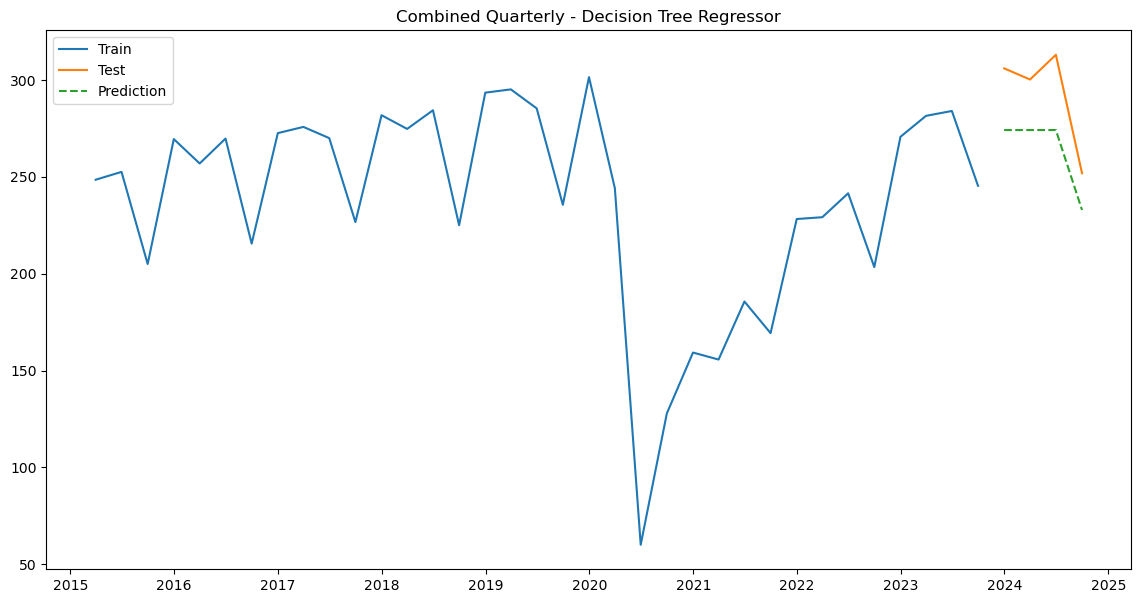

R2 Score Train: 0.4229521033094976
R2 Score Test: -0.5385926031664494


In [18]:
train_and_predict(df_autobus_trim, test_size=4, title='Autobus Quarterly')
train_and_predict(df_metro_trim, test_size=4, title='Metro Quarterly')
train_and_predict(df_combined_trim, test_size=4, title='Combined Quarterly')

In [19]:
print_metrics(df_autobus_trim, test_size=4, title='Autobus Quarterly')
print_metrics(df_metro_trim, test_size=4, title='Metro Quarterly')
print_metrics(df_combined_trim, test_size=4, title='Combined Quarterly')

Autobus Quarterly - MSE: 372.5181552134359, RMSE: 19.300729395891647, MAPE: 0.13798443860764975
Metro Quarterly - MSE: 143.93547095663286, RMSE: 11.997310988577102, MAPE: 0.06186700904932549
Combined Quarterly - MSE: 1914.60123194067, RMSE: 43.756156503293, MAPE: 0.12701553320415632


***

## Conclusión Decision Tree

Tras evaluar las predicciones de las series temporales de pasajeros de metro y autobús de Madrid utilizando el modelo DecisionTreeRegressor, se observa que los resultados obtenidos no son favorables. Las métricas de error, como el MSE, RMSE y MAPE, indican una alta discrepancia entre las predicciones y los valores reales, lo que sugiere que el modelo no ha logrado capturar adecuadamente los patrones y las dinámicas de las series temporales. Al compararlo con los modelos ETS (Error, Trend, Seasonal) y Theta, los cuales han mostrado mejores resultados tanto en términos visuales como en las métricas de error, se concluye que estos enfoques proporcionan predicciones más precisas y ajustadas a los datos. Por lo tanto, no usaremos el DecisionTreeRegressor y optaremos por modelos como ETS y Theta por el momento, que han demostrado ser más adecuados para las características de las series temporales de pasajeros.

Se utilizó validación cruzada para evaluar la capacidad predictiva del modelo DecisionTreeRegressor, con el objetivo de optimizar sus parámetros y mejorar las predicciones. A pesar de este esfuerzo, los resultados obtenidos no mejoraron significativamente en comparación con las predicciones iniciales.